# 1. Load Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import tensorflow as tf

# 2. Load Model

Here we get a famous published model: Vgg16. 

This model has been trained to label images with 1000 classes ('imagenet')

In [ ]:
from keras.applications.vgg16 import VGG16
model = VGG16()

**Task (10 min)**

- Inspect the model. 
- How many parameters does it have? 
- What are the shapes of input and output layers? 
- What is the last convolutional layer?
- Calculate the expect size of input images and store it as *input_size*

In [ ]:
%%script echo show model summary here
....

In [ ]:
%%script echo edit before running
input_layer = model.get_layer('... input layer name ...')   # alternative: model.layers[0]
last_conv_layer = model.get_layer(' ... last convolutional layer name ....')

input_shape = input_layer.output.shape
input_size  = (input_shape[1], input_shape[2])   # expected size of input images (w x h)

print('input_size:',input_size)
print('last_conv:',last_conv_layer.get_weights()[0].shape)

There are many other pre-trained models available:
See here: https://keras.io/api/applications/

# 3. Load Data

**Notice:**

- When running model predicitions on new data it is important to **preprocess** (convert, scale, normalize, ...) the picture exactly as was done for model building.
- For interpretation it will also be important to **decode** the predictions (integer $\to$ label).

To this end keras provides extra functionality: *preprocess_input* and *decode_predictions*

In [ ]:
%%script echo load file from url or locally
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

input_size=... make sure input_size was properly defined above ....

fn='elephant.jpg'
url='https://img-datasets.s3.amazonaws.com/elephant.jpg'
fn=tf.keras.utils.get_file(origin=url)

# load image
img = image.load_img(fn, target_size=input_size)
plt.imshow(img)
plt.show()

### Convert Image

In [ ]:
x = image.img_to_array(img)  # PIL -> numpy
x = x[np.newaxis, ...]       # expand to sample dimension, np.expand_dims(x, axis=0)
x = preprocess_input(x)      # preprocess as was done for Vgg16, c.f --> handwritten digits

# 4. Make Predictions

In [ ]:
preds = model.predict(x)
c_id  = np.argmax(preds)
print('Predicted:', decode_predictions(preds, top=3)[0])
print('Predicted class', c_id, decode_predictions(preds, top=1)[0])

**Task (20  min)**: 
Repeat the steps above with your own image of choice.

# 5. Visualize Parameters: Filter Maps

layer name:  block1_conv1  filters shape: (3, 3, 3, 64) 


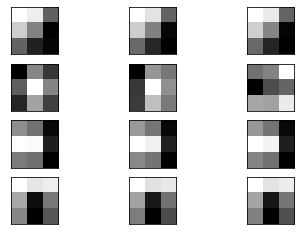

In [ ]:
layer_id=1
layer = model.layers[layer_id]
filters, biases = layer.get_weights()

print('layer name:  {}  filters shape: {} '.format(layer.name, filters.shape))

f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# Plot some selected filters
n_filters, ix = 4, 1
for i in range(n_filters):
	f = filters[:, :, :, i]
	for j in range(3):
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
plt.show()

# 6. Visualize Outputs: Feature Maps

layer: 3 name: block1_pool feature_map: (1, 112, 112, 64)


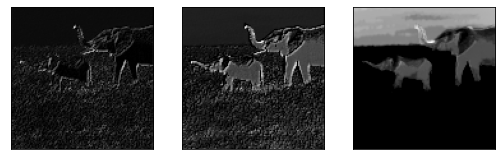

In [ ]:
i=3                                                          # layer index
layer_name = model.layers[i].name                            # layer name
output = model.layers[i].output                              # define output                     
fmodel = tf.keras.Model(inputs=model.inputs, outputs=output) # feature model
fmap   = fmodel.predict(x)                                   # feature map

nx=3   # number of feature maps to show for given layers
print('layer: {} name: {} feature_map: {}'.format(i, layer_name, fmap.shape))
 
plt.figure(figsize=(24, 24)) 
for ix in range(nx):
	ax = plt.subplot(1, 8, ix+1)
	ax.set_xticks([])
	ax.set_yticks([])
	plt.imshow(fmap[0, :, :, ix], cmap='gray')
plt.show()

**Task** repeat the above for different layers $i$

# 7. Interprete Predictions

Given a class prediction $x \to c$, how would changes in one layer effect the output value.


Saliency: gradient of input features to output

GRAD-CAM: effect of the **last convolutional layer** on the **predicted class label**

In [ ]:
! pip install tf-keras-vis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.6 MB/s 


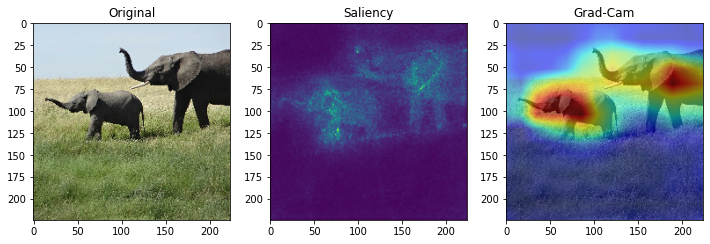

In [ ]:
from matplotlib import cm

from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# define the categories of interest (list)  # c_id is the predicted label
score = CategoricalScore([c_id])

gradcam = GradcamPlusPlus( model, model_modifier=ReplaceToLinear(), clone=True)
saliency = Saliency(model, model_modifier=ReplaceToLinear(), clone=True)

#saliency_map = saliency(score, x)
saliency_map = saliency(score, x, smooth_samples=20, smooth_noise=0.20)
                        
cam          = gradcam(score, x)
heatmap      = np.uint8(cm.jet(cam[0])[..., :3] * 255)

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Original')

ax = plt.subplot(1, 3, 2)
plt.imshow(saliency_map[0]) 
plt.title('Saliency')

ax = plt.subplot(1, 3, 3)
plt.imshow(img)
plt.imshow(heatmap, cmap='jet', alpha=0.5) 
plt.title('Grad-Cam')

plt.show()

## Uses of Grad-CAM

- understand misclassification
- robustness to adversial noise
- bias detection